This example will show how to generate the Markov chain-based analysis from [1] using the MindScoPy package

In [2]:
import mindscopy as ms
from preprocessing.artifact_removal import peak_rejection, riemannian_potato_rejection
from preprocessing.misc import epoch
from preprocessing.rebias import apply_rebias_to_groups
from preprocessing.feature_extraction import ScaledTangentSpace
import numpy as np
import pyriemann


In [3]:
# use sample data from study for now, will change this to BCI competition data later
import pickle
with open('B:/nicolas-ivanov_eeg-bci-metric-assesst_0545_data_prism/Processed Data/1-7s-preprocessed-epoched-bandpass-main.pickle', 'rb') as f:
    d = pickle.load(f)


Perform the preprocessing steps of artifact rejecting and sub-epoching.

In [4]:
data = d[2]
print(data.keys())
Xall = data['trials']
y = data['labels']
blocks = data['run_label']
print(Xall.shape)

dict_keys(['baseline', 'trials', 'raw_trials', 'labels', 'run_label'])
(360, 32, 1750)


In [5]:
# select channels
ch_map = {
    'FCz' : 0,
    'Fz' : 1,
    'FC3': 4,
    'C5': 6,
    'C3': 7,
    'C1': 8,
    'Cz': 9,
    'CP3': 10,
    'CPz': 11,
    'P7': 12,
    'P5': 13,
    'P3': 14,
    'P1': 15,
    'Pz': 16,
    'PO3': 17,
    'Oz': 18,
    'PO4': 19,
    'P8': 20,
    'P6': 21,
    'P4' : 22,
    'P2' : 23,
    'CP4': 24,
    'C6' : 26,
    'C4' : 27,
    'C2' : 28,
    'FC4' : 29,
}

sel_chs = np.asarray([ch_map[ch] for ch in ch_map])
X = Xall[:, sel_chs, :]

In [6]:
print(X.shape)

(360, 26, 1750)


In [7]:
# apply peak rejection
X, rejected_trials = peak_rejection(X, threshold=350, verbose=True)
y = np.delete(y, rejected_trials)
blocks = np.delete(blocks, rejected_trials)


3 trials rejected.


In [8]:
# apply riemannian potato rejection to each block of trials
clean_X = []
clean_y = []
clean_blocks = []
for block in np.unique(blocks):
    block_idx = blocks == block
    X_block = X[block_idx]
    y_block = y[block_idx]
    blocks_block = blocks[block_idx]

    X_block, rejected_trials = riemannian_potato_rejection(X_block, threshold=2.5, verbose=True)
    y_block = np.delete(y_block, rejected_trials)
    blocks_block = np.delete(blocks_block, rejected_trials)

    clean_X.append(X_block)
    clean_y.append(y_block)
    clean_blocks.append(blocks_block)

X = np.concatenate(clean_X)
y = np.concatenate(clean_y)
blocks = np.concatenate(clean_blocks)

Iteration 0: 3 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 3 total trials rejected.
Iteration 0: 6 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 6 total trials rejected.
Iteration 0: 5 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 5 total trials rejected.
Iteration 0: 8 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 8 total trials rejected.


Now compute the mean covariance matrix for each block. These will be used for rebiasing the sub-epoch covariance matrices.

In [9]:
Nt, Nc, Ns = X.shape
Nblks = len(np.unique(blocks))

# block means
block_means = np.zeros((Nblks, Nc, Nc))
for i, block in enumerate(np.sort(np.unique(blocks))):
    block_covs = pyriemann.utils.covariance.covariances(X[blocks == block])
    block_means[i] = pyriemann.utils.mean.mean_covariance(block_covs)

In [10]:
# Generate sub-epochs for each trial
Fs = 250
length = 1
stride = 0.5
Ns_epoch = int(Fs * length)
Xcluster = epoch(X, Ns_epoch, int(Fs * stride))

In [11]:
Nclust_epochs = Xcluster.shape[1]

In [12]:
# apply the rebiasing to the sub-epochs
blocks_clust_epochs = np.repeat(blocks, Xcluster.shape[1])

Xcluster = np.reshape(Xcluster, (-1, Nc, Ns_epoch))
Xclust_covs = pyriemann.utils.covariance.covariances(Xcluster)

Xclust_covs = apply_rebias_to_groups(Xclust_covs, blocks_clust_epochs, block_means)

In [13]:
y_seg = np.repeat(y, Nclust_epochs)
Xtask_covs = Xclust_covs[y_seg != 0]

In [14]:
# apply feature extraction
feature_extractor = ScaledTangentSpace().fit(Xclust_covs)
Xclust_features = feature_extractor.transform(Xclust_covs)

feature_extractor.fit(Xtask_covs)
Xtask_features = feature_extractor.transform(Xtask_covs)

In [15]:
# put the data back into trial, epoch, format
Xclust_features = np.reshape(Xclust_features, (Nt, Nclust_epochs, -1))
print(Xclust_features.shape)
Ntask_trials = np.sum(y != 0)
Xtask_features = np.reshape(Xtask_features, (Ntask_trials, Nclust_epochs, -1))


(335, 13, 351)


In [16]:
# Perform clustering and generate the trajectory sub-space
np.random.seed(42)
all_state_space = ms.Markov_State_Space(krange=range(3,8)).fit(Xclust_features, verbose=True)

# create a state space for the task data only
task_state_space = ms.Markov_State_Space(krange=range(3,8)).fit(Xtask_features, verbose=True)

Selecting the number of clusters using prediction strength.
Number of clusters selected: 7
Selecting the number of clusters using prediction strength.
Number of clusters selected: 6


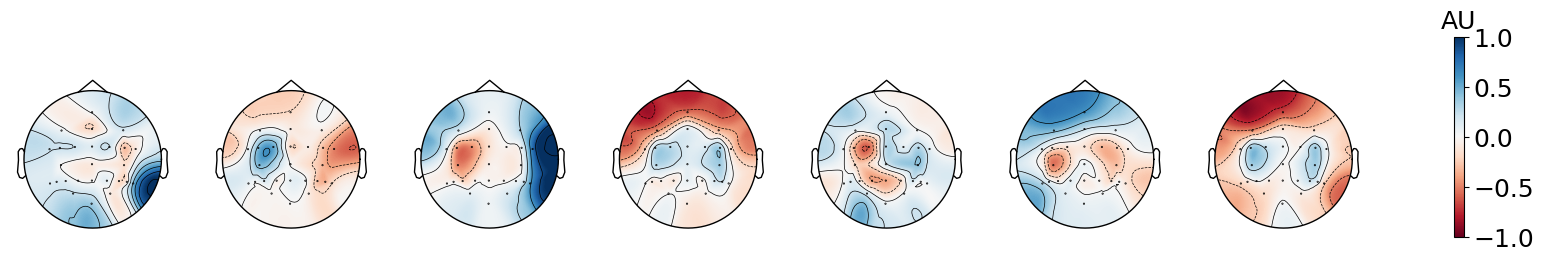

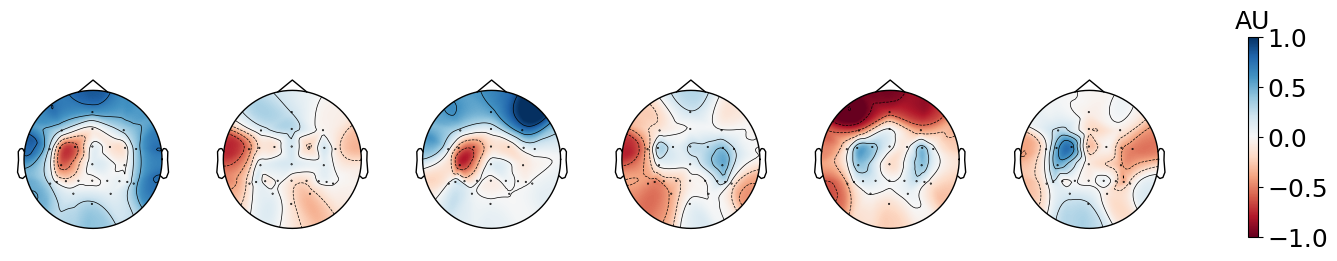

In [17]:
# visulize the pattern state activation patterns
all_state_space.plot_state_activation_patterns(np.reshape(Xclust_features, (-1, Xclust_features.shape[-1])), Xclust_covs, list(ch_map.keys()))
task_state_space.plot_state_activation_patterns(np.reshape(Xtask_features, (-1, Xtask_features.shape[-1])), Xtask_covs, list(ch_map.keys()))

In [18]:
# create Markov State Transition Matrix for each task
ytask = y[y != 0]
labels = np.unique(ytask)
models = [None] * len(labels)
for i, label in enumerate(labels):
    Xlabel = Xtask_features[ytask == label]
    S = task_state_space.transform(Xlabel)
    print(S.shape)
    models[i] = ms.Markov_Model(task_state_space).fit(np.reshape(S, (-1, Nclust_epochs)), verbose=True)

(728,)
Transition matrix:
[[0.74084249 0.01268315 0.10663919 0.02834249 0.01268315 0.09880952]
 [0.06488095 0.43287546 0.1040293  0.12751832 0.14317766 0.12751832]
 [0.16536172 0.10272436 0.41591117 0.07923535 0.11055403 0.12621337]
 [0.03547619 0.06940476 0.03547619 0.64619048 0.14404762 0.06940476]
 [0.00833333 0.06817585 0.06069554 0.21030184 0.58431759 0.06817585]
 [0.08494624 0.05430108 0.0313172  0.07728495 0.09260753 0.65954301]]
(754,)
Transition matrix:
[[0.72083333 0.0155303  0.13068182 0.02992424 0.0155303  0.0875    ]
 [0.0494916  0.45771441 0.10240937 0.11752874 0.17044651 0.10240937]
 [0.13768789 0.10744916 0.50055261 0.06209107 0.08477011 0.10744916]
 [0.06713086 0.12004863 0.05957118 0.48291335 0.18808576 0.08225022]
 [0.00833333 0.078      0.03366667 0.14766667 0.66066667 0.07166667]
 [0.10240937 0.06461096 0.10240937 0.07973033 0.08729001 0.56354996]]
(715,)
Transition matrix:
[[0.74187764 0.02035865 0.09852321 0.0564346  0.00833333 0.07447257]
 [0.03911422 0.49351981

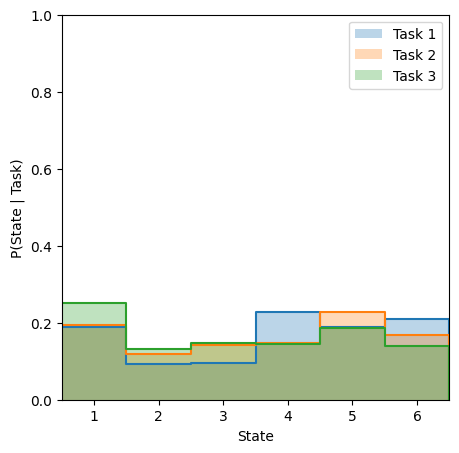

0.09409623797138504


In [19]:
# compute the taskDistinct
td = ms.task_distinct(models, visualize=True)
print(td)

In [20]:
# create a Markov State Transition Matrix for all tasks and rest
models = [None] * (len(labels) + 1)
for i, label in enumerate(labels):
    Xlabel = Xclust_features[y == label]
    S = all_state_space.transform(Xlabel)
    models[i] = ms.Markov_Model(all_state_space).fit(np.reshape(S, (-1, Nclust_epochs)), verbose=True)
S = all_state_space.transform(Xclust_features[y == 0])
models[-1] = ms.Markov_Model(all_state_space).fit(np.reshape(S, (-1, Nclust_epochs)), verbose=True)

Transition matrix:
[[0.47953297 0.1415522  0.15982143 0.06847527 0.05020604 0.05020604
  0.05020604]
 [0.09210221 0.57868757 0.05348432 0.07665505 0.05348432 0.01486643
  0.13072009]
 [0.15460165 0.11806319 0.50171703 0.03585165 0.02671703 0.11806319
  0.04498626]
 [0.01439477 0.05790622 0.01439477 0.6525627  0.05065431 0.02164667
  0.18844057]
 [0.06586538 0.12067308 0.09326923 0.14807692 0.32163462 0.11153846
  0.13894231]
 [0.09848901 0.10762363 0.17156593 0.0893544  0.1532967  0.26291209
  0.11675824]
 [0.00714286 0.11929563 0.04012897 0.15887897 0.0797123  0.02693452
  0.56790675]]
Transition matrix:
[[0.51832133 0.0773399  0.25373247 0.03324176 0.03324176 0.04206139
  0.04206139]
 [0.06348049 0.5309208  0.05466086 0.11639826 0.04584123 0.08111974
  0.10757863]
 [0.17561576 0.09623911 0.39610648 0.06978022 0.05214096 0.14033725
  0.06978022]
 [0.02259001 0.09982578 0.02259001 0.54779326 0.10754936 0.02259001
  0.17706156]
 [0.03576165 0.03576165 0.04458128 0.16805608 0.45910383 0.

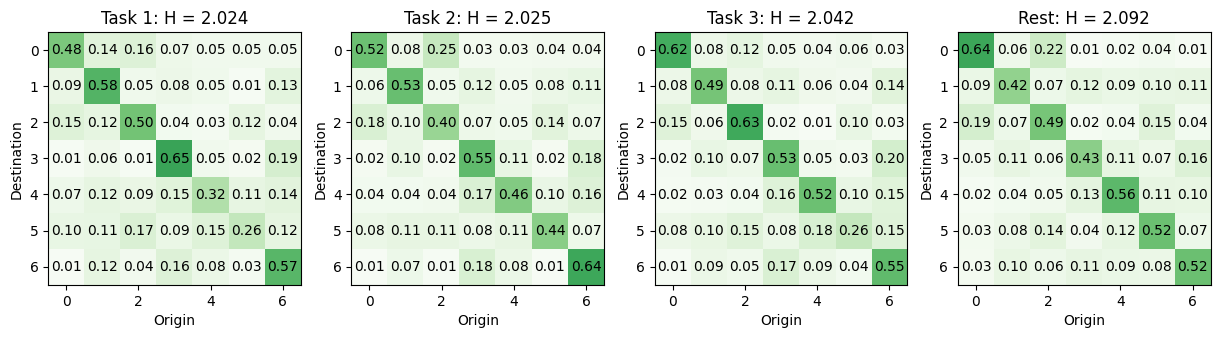

0.9800999732986784


In [21]:
# Compute relativeTaskInconsistency
rel_task_incon = ms.relative_task_inconsistency(models[:-1], models[-1], visualize=True)
print(rel_task_incon)